# Múltiples Capas

## Objetivo
El **objetivo** de esta libreta es dar a conocer el esquema básico bajo el cual se pueden manipular diferentes
capas en `TensorFlow`. Una vez hecho esto se podrá visualizar todo el _grafo de computación_ mediante
`TensorBoard` para analizar con detalle todos los pasos que se siguen al realizar operaciones más complicadas.

## Procedimiento
El procedimiento a seguir en esta libreta es el siguiente:

1. Se crea una imagen de 8 pixeles de forma aleatoria y se le implementa un simple filtro de promedio.
En particular este filtro como funciona es que toma un tamaño de la imagen y promedia el número de pixeles
que se defina, por lo que resultará en una imagen más pequeña. En este caso será un promedio simple, por lo
tanto resultará una imagen de 4 pixeles.

2. Después se creará una capa personalizada donde se harán algunas de las operaciones que ya se conocen
para demostrar cómo es que `TensorFlow` permite la conexión y comunicación de datos entre capas.

3. Por último, se pretende guardar todas estas operaciones tal que posteriormente se puedan visualizar como un grafo
de computación utilizando `TensorBoard`.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

session = tf.Session()

## Promedio móvil (Filtro espacial)
El tipo de _filtro_ que se implementará aquí es una operación conocida coloquialmente como _promedio móvil_, sin embargo su nombre
formal es **filtro espacial.** Esto es en general el campo de estudio del _procesamiento digital de imágenes_ y como tal no está
dentro del alcance de esta libreta; como referencia se deja el libro de [González & Woods](http://www.imageprocessingplace.com/)
que es el estándar para esta área.

Básicamente, se tendrá una matriz y se le aplicará el promedio mediante una operación matemática llamada _convolución,_ sin embargo
el término correcto es una _correlación_ dado que es un filtro _móvil_ y se define por la siguiente operación:
$$ w(x, y) \star f(x, y) = \sum_{s=-a}^{a} \sum_{t=-b}^{b} w(s, t) f(x+s, y+t).$$
Por el momento no es necesario darle tanto detalle a esta operación, por lo pronto se utilizará como una caja negra.
En particular esta operación está definida en `TensorFlow` como `conv2d` por lo que no hay necesidad de implementarla, de hecho es una
operación muy común en el área de imágenes, visión por computadora e inteligencia artificial.

## Detalles del ejemplo presentado
Para crear la imagen aleatoria y poder realizar la _correlación_ con el filtro entonces se debe crear una imagen con un tamaño muy
característico, donde cada elemento de la lista de dimensión corresponde a los siguientes elementos:

1. Número de la imagen

2. Altura

3. Ancho

4. Número de canales de color

De esta forma se creará una imagen aleatoria con `numpy` y con esta información se trabajará durante toda la libreta.

In [2]:
# Definir el tamaño de la imagen como se ha mencionado
x_shape = [1, 4, 4, 1]
x_val = np.random.uniform(size=x_shape)
x_val

array([[[[0.15611847],
         [0.31895929],
         [0.88520538],
         [0.544918  ]],

        [[0.24391134],
         [0.9904592 ],
         [0.63431371],
         [0.62491614]],

        [[0.05575135],
         [0.94048611],
         [0.61008244],
         [0.47641165]],

        [[0.03910864],
         [0.92118179],
         [0.18467528],
         [0.39812862]]]])

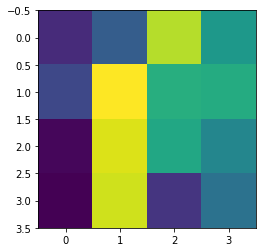

In [3]:
# Se puede observar la imagen cambiando el tamaño del arreglo
plt.imshow(x_val.reshape(4, 4))

In [4]:
# Para operar con la imagen, se crea un placeholder de TensorFlow
x_data = tf.placeholder(tf.float32, shape=x_shape)

In [5]:
# El tamaño del promedio, es 1/4
filtro = tf.constant(0.25, shape=[2, 2, 1, 1])
# Esta lista es la forma cómo se mueve el filtro
strides = [1, 2, 2, 1]
# Capa de promedio móvil
prom_movil = tf.nn.conv2d(x_data, filtro, strides, padding='SAME', 
name='Promedio_Movil')

## Sobre la _convolución_ en `TensorFlow`
La [convolución en TensorFlow](https://www.tensorflow.org/versions/r1.9/api_guides/python/nn#Convolution) tiene una forma de
implementación diferente y única que se debe leer la documentación con cuidado. Aquí se mencionan algunos detalles importantes:

1. El _filtro_ aplicado debe de tener el mismo tamaño que los datos de la imagen.

2. Los _strides_ son la forma cómo se mueve el filtro. Según la [documentación](https://www.tensorflow.org/versions/r1.9/api_docs/python/tf/nn/conv2d?hl=en#args)
se tiene que corresponde a los mismos valores que los datos originales, es decir a la lista que se tiene en la celda anterior donde se describen por primera
vez estos datos.

3. La opción de `padding` es un término del área de _procesamiento digital de imágenes_ lo cual es algo análogo a un _margen_ en imágenes
y esto se hace para no perder información en las orillas de la imagen. En particular, `SAME` viene descrito con mucho más detalle en la
[documentación](https://www.tensorflow.org/versions/r1.9/api_guides/python/nn#Notes_on_SAME_Convolution_Padding).

In [6]:
# Producir la imagen filtrada y mostrar los datos
img_prom = session.run(prom_movil, feed_dict={x_data: x_val})
img_prom

array([[[[0.42736205],
         [0.6723383 ]],

        [[0.48913196],
         [0.41732448]]]], dtype=float32)

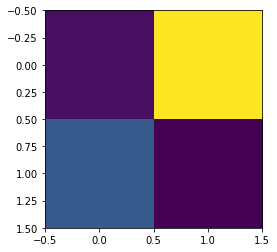

In [7]:
# Mostrar ahora la imagen encontrada que corresponde a estos datos
plt.imshow(img_prom.reshape(2, 2))

Esta siguiente parte consta de crear una capa personalizada con operaciones diversas, es importante
notar que en realidad no significa nada como tal, no tiene un fundamento matemático o riguroso, la idea es simplemente
ilustrar lo que se puede llevar a cabo cuando se tienen múltiples capas.

En particular, lo que se pretende ahora es tomar la matriz resultado de las operaciones anteriores y realizar las
siguientes operaciones matemáticas:

\begin{equation}
\vec{b} = \mathbf{A} \cdot \vec{x} + \vec{b}, \text{y después aplicar la función sigmoide} \\
\vec{c} = \frac{1}{1 + e^{-\vec{b}}} .
\end{equation}

Con esto se tienen dos capas de cómputo donde el resultado de una capa tiene que ser la entrada de la otra capa, por lo
que en `TensorFlow` deben de existir algunos ajustes a los datos originales de la imagen.

In [8]:
def capa_personalizada(input_matrix):
    # Reducir dimensiones redundantes en los datos
    input_matrix_squeezed = tf.squeeze(input_matrix)
    # Crear una "matriz" dummy, los valores son inventados
    a_mat = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    # Así como los valores de b
    b = tf.constant(1.0, shape = [2, 2])
    # Realizar la multiplicación de arreglos
    temp1 = tf.matmul(a_mat, input_matrix_squeezed)
    # Y sumar el vector adicional
    temp2 = tf.add(temp1, b)
    
    # Regresar el resultado aplicando la función sigmoide
    return tf.sigmoid(temp2)

In [9]:
# Se tiene que realizar una entrada en el grafo basándose en la función
# personalizada que se acaba de crear
with tf.name_scope('Custom_Layer') as scope:
    customlayer1 = capa_personalizada(prom_movil)

In [10]:
# Estas linea permite guardar los resultados de todo el grafo computacional
writer = tf.summary.FileWriter("multiples-capas", session.graph)
# Asignar el valor resultante
img_sigm = session.run(customlayer1, feed_dict={x_data: x_val})
# Terminar de escribir y cerrar archivos
writer.close()

Esta última celda permite guardar los datos obtenidos del grafo en un directorio, con nombre `multiples-capas` que después
podrá ser visualizado con `TensorBoard`.

`TensorBoard` ya viene instalado por default cuando se install `TensorFlow` por lo que no debe haber problemas de
compatibilidad en esta parte. Para poder visualizar la parte del grafo sólo basta ejecutar el siguiente comando en la
terminal:
```bash
tensorboard --logdir="multiples-capas"
```
y para que funcione se debe estar posicionado en el directorio que contenga a `multiples-capas`.

In [11]:
# Mostrar los resultados obtenidos como números
img_sigm

array([[0.9172553, 0.9246302],
       [0.9857777, 0.9908636]], dtype=float32)

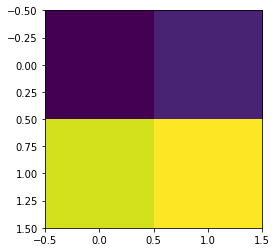

In [12]:
# Y mostrar los mismos resultados como imagen
plt.imshow(img_sigm.reshape(2, 2))